In [1]:
import warnings
warnings.filterwarnings("ignore")
import  numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

## Load Data

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
print(f"Number of Rows {df.shape[0]} and number of colummns {df.shape[1]}")

Number of Rows 768 and number of colummns 9


## Data Imputation

In [5]:
def cal_median(df,target,var):
    temp = df[df[var].notnull()]
    temp = temp[[var,target]].groupby([target])[[var]].median().reset_index()
    return temp

In [6]:
def median_imputation(df,target,var,var_0,var_1):
    for i in range(len(df)):
        if df.loc[i,target] == 0 and df.loc[i,var] == 0:
            df.loc[i,var]=var_0
                             
        if df.loc[i,target] == 1 and df.loc[i,var] == 0:
            df.loc[i,var] = var_1

In [7]:
d = cal_median(df,"Outcome","Insulin")
d

,Outcome,Insulin
0,0,39.0
1,1,0.0


In [8]:
median_imputation(df,"Outcome","Insulin",d.loc[0,"Insulin"],d.loc[1,"Insulin"])

In [9]:
d=cal_median(df,"Outcome","Glucose")
d

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [10]:
median_imputation(df,"Outcome","Glucose",d.loc[0,"Glucose"],d.loc[1,"Glucose"])

In [11]:
d=cal_median(df,"Outcome","SkinThickness")
d

,Outcome,SkinThickness
0,0,21.0
1,1,27.0


In [12]:
median_imputation(df,"Outcome","SkinThickness",d.loc[0,"SkinThickness"],d.loc[1,"SkinThickness"])

In [13]:
d=cal_median(df,"Outcome","BloodPressure")
d

,Outcome,BloodPressure
0,0,70.0
1,1,74.0


In [14]:
median_imputation(df,"Outcome","BloodPressure",d.loc[0,"BloodPressure"],d.loc[1,"BloodPressure"])

In [15]:
d=cal_median(df,"Outcome","BMI")
d

,Outcome,BMI
0,0,30.05
1,1,34.25


In [16]:
median_imputation(df,"Outcome","BMI",d.loc[0,"BMI"],d.loc[1,"BMI"])

## EDA

In [17]:
import plotly.express as exp
import plotly.io as pio

def plot_data(df,varx,vary,target):
    pio.templates.default="simple_white"
    exp.defaults.template = "ggplot2"
    exp.defaults.color_continuous_scale = exp.colors.sequential.Blackbody
    exp.defaults.width = 800
    exp.defaults.height = 600
    fig = exp.scatter(df,x=varx,y=vary,color=target)
    fig.show()

In [18]:
df.loc[:,"N1"] = 1
df.loc[(df['Age']<=30) & (df['Glucose']<=120),"N1"]=0
df.loc[(df['Age']>30) & (df['Age']<48) & (df['Glucose']<=88),"N1"]=0 # extra
df.loc[(df['Age']>=63) & (df['Glucose']<=142),"N1"]=0 # extra

In [19]:
df.loc[:,'N2']=1
df.loc[(df['BMI']<=30),'N2']=0

In [20]:
df.loc[:,'N3']=1
df.loc[(df['Age']<=27) & (df['Pregnancies']<=6),'N3']=0
df.loc[(df['Age']>60) & (df['Pregnancies']>7.5),'N3']=0 # extra

In [21]:
df.loc[:,'N4']=1
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']>83),'N4']=0 #extra 

In [22]:
df.loc[:,'N5']=1
df.loc[(df['SkinThickness']<=20) ,'N5']=0

In [23]:
df.loc[:,'N6']=1
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=0
df.loc[(df['BMI']>33) & (df['SkinThickness']<=20),'N6']=0 # extra

In [24]:
df.loc[:,'N7']=1
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI'] >=40),'N7']=0 # extra rule included

In [25]:
df.loc[:,'N9']=1
df.loc[(df['Insulin']<200),'N9']=0

In [26]:
df.loc[:,'N10']=1
df.loc[(df['BloodPressure']<80),'N10']=0

In [27]:
df.loc[:,'N11']=1
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N11']=0

In [28]:
df['N0'] = df['BMI'] * df['SkinThickness']

df['N8'] =  df['Pregnancies'] / df['Age']

df['N13'] = df['Glucose'] / df['DiabetesPedigreeFunction']

df['N12'] = df['Age'] * df['DiabetesPedigreeFunction']

In [29]:
df.loc[:,'N15']=1
df.loc[(df['N0']<1034) ,'N15']=0

In [30]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N1,...,N6,N7,N9,N10,N11,N0,N8,N13,N12,N15
0,6,148,72,35,0,33.6,0.627,50,1,1,...,1,1,0,0,1,1176.0,0.120000,236.044657,31.350,1
1,1,85,66,29,39,26.6,0.351,31,0,0,...,1,0,0,0,0,771.4,0.032258,242.165242,10.881,0
2,8,183,64,27,0,23.3,0.672,32,1,1,...,1,1,0,0,1,629.1,0.250000,272.321429,21.504,0
3,1,89,66,23,94,28.1,0.167,21,0,0,...,1,0,0,0,0,646.3,0.047619,532.934132,3.507,0
4,0,137,40,35,168,43.1,2.288,33,1,1,...,1,1,0,0,1,1508.5,0.000000,59.877622,75.504,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0,...,1,1,0,0,1,1579.2,0.158730,590.643275,10.773,1
764,2,122,70,27,39,36.8,0.340,27,0,1,...,1,1,0,0,0,993.6,0.074074,358.823529,9.180,0
765,5,121,72,23,112,26.2,0.245,30,0,1,...,1,1,0,0,1,602.6,0.166667,493.877551,7.350,0
766,1,126,60,27,0,30.1,0.349,47,1,1,...,1,1,0,0,0,812.7,0.021277,361.031519,16.403,0


In [31]:
y=pd.DataFrame(df["Outcome"])
x= df.drop("Outcome",axis=1)

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in y.columns:
    y[col]= encoder.fit_transform(y[col])

In [33]:
y = y["Outcome"]

In [34]:
cols=["N1","N2","N3","N4","N5","N6","N7","N9","N10","N11"]
for col in cols:
    x[col]=encoder.fit_transform(x[col])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

# Decision Tree

In [36]:
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,
                           max_samples=100,bootstrap=True,n_jobs=-1,random_state=42,
                           oob_score=True)
bagging.fit(x_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

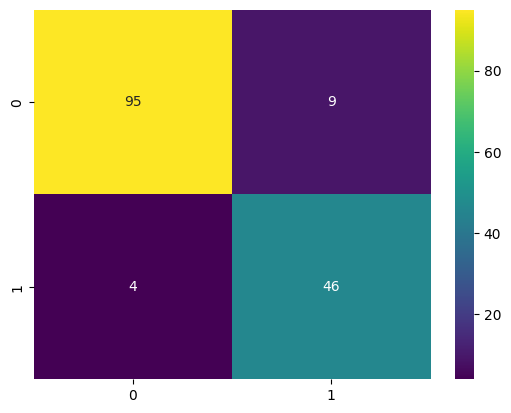

In [37]:
confusion_matrix = confusion_matrix(bagging.predict(x_test),y_test)
sb.heatmap(confusion_matrix,annot=True,fmt="0.2g",cmap="viridis")
plt.show()

In [38]:
print(classification_report(bagging.predict(x_test),y_test))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       104
           1       0.84      0.92      0.88        50

    accuracy                           0.92       154
   macro avg       0.90      0.92      0.91       154
weighted avg       0.92      0.92      0.92       154



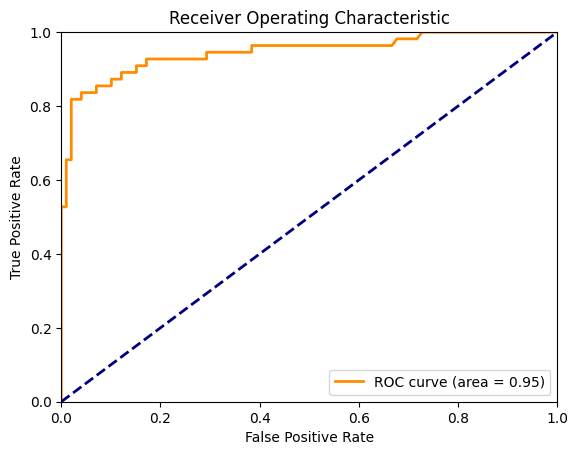

In [39]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
y_probs = bagging.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# XGBoost

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)
xgbc = xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators= 2000,
 max_depth= 9,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)

In [41]:
print(classification_report(y_test,xgbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91        99
           1       0.85      0.84      0.84        55

    accuracy                           0.89       154
   macro avg       0.88      0.88      0.88       154
weighted avg       0.89      0.89      0.89       154



# LDA

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(x_train,y_train)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
import seaborn as sns

In [43]:
lda_y_pred = lda.predict(x_test)

<Axes: >

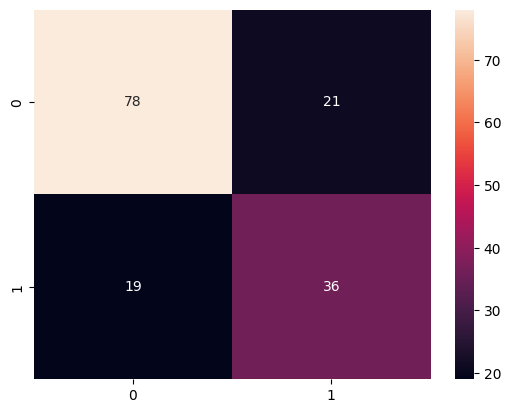

In [44]:
from sklearn.metrics import confusion_matrix
lda_cm = confusion_matrix(y_test,lda_y_pred)
sns.heatmap(lda_cm,annot = True)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,lda_y_pred)

0.7402597402597403

# Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [47]:
model = LogisticRegression(penalty='l1',C=1.0,solver='liblinear',fit_intercept=True,class_weight='balanced')

In [48]:
model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [49]:
y_pred = model.predict(x_test)

<Axes: >

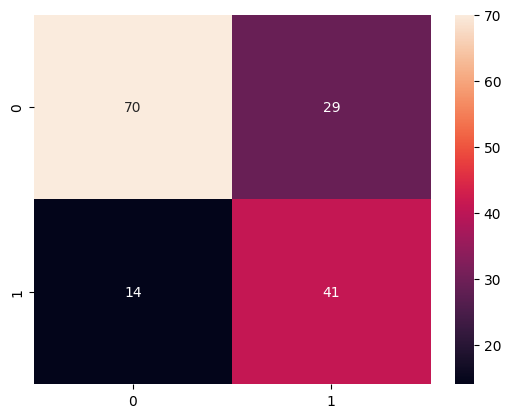

In [50]:
confusion = metrics.confusion_matrix(y_test,y_pred)
sns.heatmap(confusion,annot=True)

In [51]:
print('Accuracy of Logistic Regression is: ', model.score(x_test,y_test) * 100,'%')

Accuracy of Logistic Regression is:  72.07792207792207 %


# Gradient Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [53]:
model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=15,max_depth=4,min_samples_split=2,min_samples_leaf=1,subsample=0.8,max_features='sqrt')
model.fit(x_train,y_train)

GradientBoostingClassifier(max_depth=4, max_features='sqrt', n_estimators=15,
                           subsample=0.8)

In [54]:
y_pred = model.predict(x_test)

<Axes: >

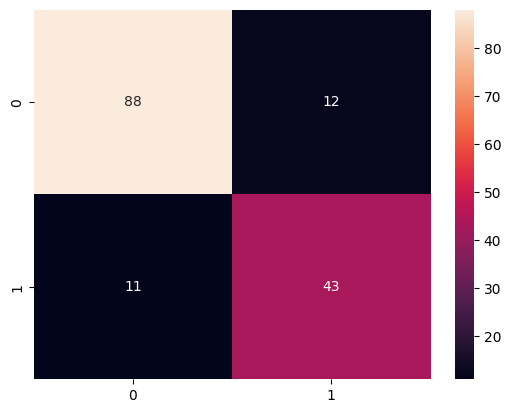

In [55]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True)

In [56]:
print('Accuracy of Gradient Boost is: ', model.score(x_test,y_test) * 100,'%')

Accuracy of Gradient Boost is:  85.06493506493507 %


# SVM

In [57]:
from sklearn.svm import SVC
svc = SVC(kernel="linear",random_state=0)
svc.fit(x_train,y_train)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics

In [58]:
svc_y_pred = svc.predict(x_test)

<Axes: >

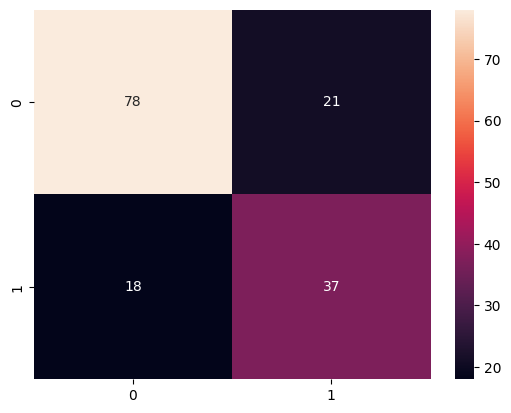

In [59]:
svc_cm = confusion_matrix(y_test,svc_y_pred)
sns.heatmap(svc_cm,annot=True)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test,svc_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        99
           1       0.64      0.67      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



# Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics

In [62]:
clf_y_pred = clf.predict(x_test)

<Axes: >

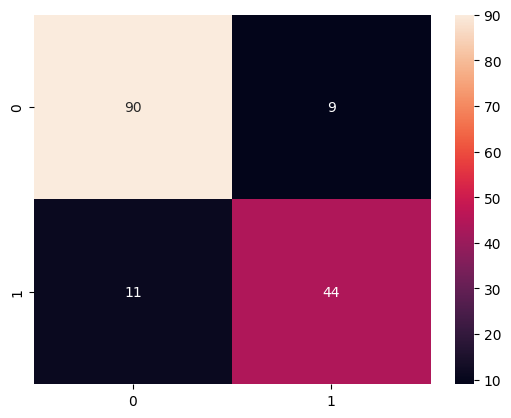

In [63]:
from sklearn.metrics import confusion_matrix
clf_cm = confusion_matrix(y_test,clf_y_pred)
sns.heatmap(clf_cm,annot = True)

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,clf_y_pred)

0.8701298701298701

# Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=0.01)
gnb.fit(x_train,y_train)

GaussianNB(var_smoothing=0.01)

In [66]:
gnb_y_pred = gnb.predict(x_test)

<Axes: >

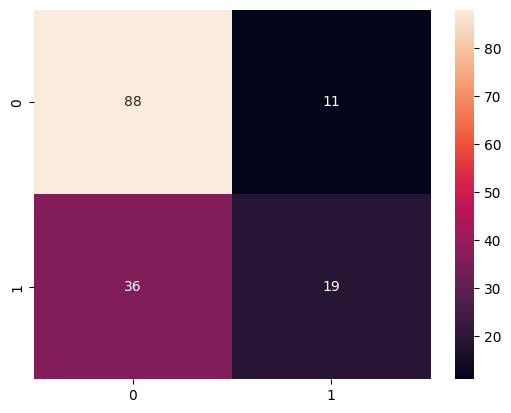

In [67]:
from sklearn.metrics import confusion_matrix
gnb_cm = confusion_matrix(y_test,gnb_y_pred)
sns.heatmap(gnb_cm,annot = True)

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,gnb_y_pred)

0.6948051948051948

# Neural Networks

In [69]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(100,50),activation='tanh',solver='lbfgs',alpha=0.0001,learning_rate='adaptive',learning_rate_init=0.001,max_iter=100,batch_size='auto',early_stopping=True,validation_fraction=0.1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

<Axes: >

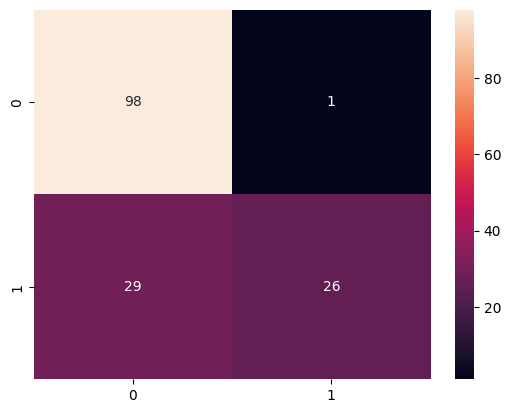

In [70]:
from sklearn.metrics import confusion_matrix
nn_cm = confusion_matrix(y_test,predictions)
sns.heatmap(nn_cm,annot = True)

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.8051948051948052

# Difference among the models

In [72]:
models = {
    'Decision Tree': BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,
                           max_samples=100,bootstrap=True,n_jobs=-1,random_state=42,
                           oob_score=True),
    'XGboost': xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators= 2000,
 max_depth= 9,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(n_components=1),
    'Logistic Regression': LogisticRegression(penalty='l1',C=1.0,solver='liblinear',fit_intercept=True,class_weight='balanced'),
    'Gradient Boost': GradientBoostingClassifier(learning_rate=0.1,n_estimators=15,max_depth=4,min_samples_split=2,min_samples_leaf=1,subsample=0.8,max_features='sqrt'),
    'Support Vector Machine': SVC(kernel="linear",random_state=0),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Naive Bayes': GaussianNB(var_smoothing=0.01),
    'Neural Networks': MLPClassifier(hidden_layer_sizes=(100,50),activation='tanh',solver='lbfgs',alpha=0.0001,learning_rate='adaptive',learning_rate_init=0.001,max_iter=100,batch_size='auto',early_stopping=True,validation_fraction=0.1)
}

In [73]:
accuracies = {}
for name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accuracies[name] = accuracy_score(y_test,y_pred)

In [74]:
accuracy_df = pd.DataFrame(list(accuracies.items()),columns=['Model','Accuracy'])
accuracy_df.set_index('Model',inplace=True)

In [75]:
difference_table=accuracy_df.T.apply(lambda x: x-x.mean(),axis=1)

In [76]:
def color_negative_red(val):
    color = 'red' if val < 0 else 'green'
    return f'color: {color}'

def highlight_max(s):
    is_max = s == s.max()
    return ['background_color: yellow' if v else '' for v in is_max]

In [77]:
print("Accuracy Table:")
styled_accuracy_df = accuracy_df.style.applymap(color_negative_red).apply(highlight_max)
display(styled_accuracy_df)

Accuracy Table:


,Accuracy
Model,
Decision Tree,0.915584
XGboost,0.889610
Linear Discriminant Analysis,0.740260
Logistic Regression,0.720779
Gradient Boost,0.883117
Support Vector Machine,0.746753
Random Forest,0.876623
Naive Bayes,0.694805
Neural Networks,0.837662


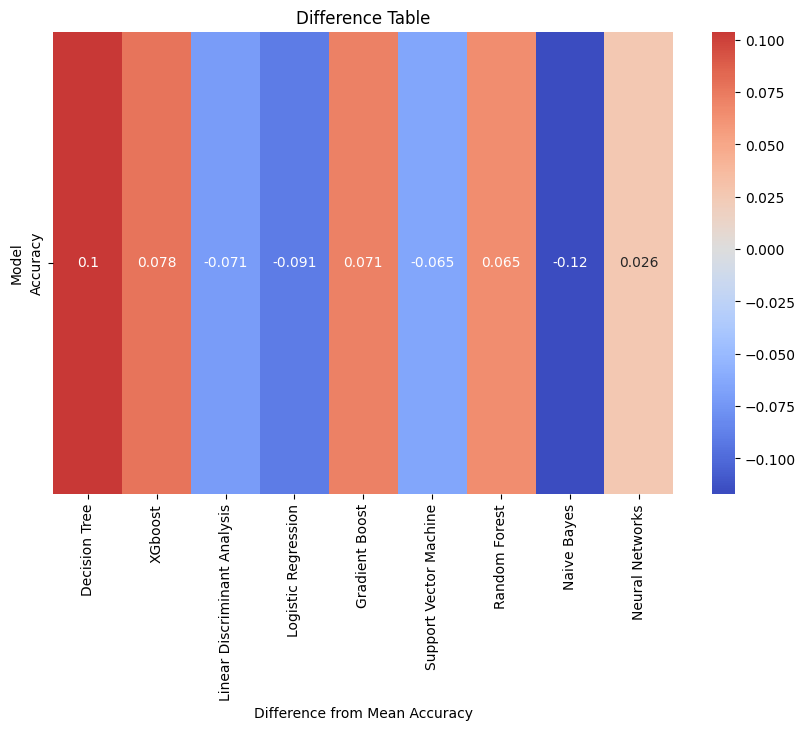

In [78]:
plt.figure(figsize=(10,6))
sns.heatmap(difference_table,annot=True,cmap='coolwarm',center=0)
plt.title('Difference Table')
plt.ylabel('Model')
plt.xlabel('Difference from Mean Accuracy')
plt.show()

In [79]:
print("\nDifference Table:")
styled_difference_table = difference_table.style.applymap(color_negative_red).apply(highlight_max,axis=1)
display(styled_difference_table)


Difference Table:


Model,Decision Tree,XGboost,Linear Discriminant Analysis,Logistic Regression,Gradient Boost,Support Vector Machine,Random Forest,Naive Bayes,Neural Networks
Accuracy,0.103896,0.077922,-0.071429,-0.090909,0.071429,-0.064935,0.064935,-0.116883,0.025974
